<a href="https://colab.research.google.com/github/andrespollano/neural_nets-tda/blob/main/BERT/TDA_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers
!pip install giotto-tda
!pip install umap-learn
!pip install umap-learn[plot]

## Load datasets

In [2]:
from datasets import load_dataset

In [3]:
# Load the dataset
imdb_data = load_dataset('imdb')

# Access train and test splits
imbd_train = imdb_data['train']
imbd_test = imdb_data['test']

# Print out a sample review
print(imbd_train[0]['text'])
print(imbd_train[0]['label'])

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [4]:
# Load the dataset
news_data = load_dataset('heegyu/news-category-dataset')

# Access train and test splits
news_train = news_data['train']
#news_test = news_data['test']

# Print out a sample news
print(news_train[0]['short_description'])
print(news_train[0]['category'])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.
U.S. NEWS


## Extract Attention Weights

In [5]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
MAX_LEN = 128

def get_attention_weights(model, tokenizer, sentences, MAX_LEN):
  inputs = tokenizer(sentences, return_tensors="pt", padding='max_length', truncation=True, max_length=MAX_LEN)

  # Feed sentences to BERT model
  with torch.no_grad():
      outputs = model(**inputs)

  # Extract the attention weights from the output
  attentions = outputs.attentions  # This will be a tuple with 12 elements for BERT base
  #attentions = np.asarray([layer.cpu().detach().numpy() for layer in attentions], dtype=np.float16)  # Convert to Numpy array

  return attentions

In [7]:
# Example Usage:
sentences = ["Hello world!", "BERT is a transformer model."]
attentions = get_attention_weights(model, tokenizer, sentences, MAX_LEN)
print(f'Number of layers: {len(attentions)}')
print(f'Shape of each layer: {attentions[0].shape}')  #  Print shape of first layer

Number of layers: 12
Shape of each layer: torch.Size([2, 12, 128, 128])


In [8]:
# Load news data for 3 categories
politics_data = news_train.filter(lambda example: example['category'] == 'POLITICS')
business_data = news_train.filter(lambda example: example['category'] == 'BUSINESS')
entertainment_data = news_train.filter(lambda example: example['category'] == 'ENTERTAINMENT')

# Combine 'headline' and 'short_description'
def combine_fields(example):
    example['combined'] = example['headline'] + ". " + example['short_description']
    return example

combined_politics_data = politics_data.map(combine_fields)
combined_business_data = business_data.map(combine_fields)
combined_entertainment_data = entertainment_data.map(combine_fields)

Filter:   0%|          | 0/209527 [00:00<?, ? examples/s]

Filter:   0%|          | 0/209527 [00:00<?, ? examples/s]

Filter:   0%|          | 0/209527 [00:00<?, ? examples/s]

Map:   0%|          | 0/35602 [00:00<?, ? examples/s]

Map:   0%|          | 0/5992 [00:00<?, ? examples/s]

Map:   0%|          | 0/17362 [00:00<?, ? examples/s]

In [9]:
# Get the first combined entries for each category
n_examples = 10
headlines_politics = [entry['combined'] for entry in combined_politics_data][:n_examples]
headlines_business = [entry['combined'] for entry in combined_business_data][:n_examples]
headlines_entertainment = [entry['combined'] for entry in combined_entertainment_data][:n_examples]

print(f'Politics: {headlines_politics[0]}')
print(f'Business: {headlines_business[0]}')
print(f'Entertainment: {headlines_entertainment[0]}')

Politics: Biden Says U.S. Forces Would Defend Taiwan If China Invaded. President issues vow as tensions with China rise.
Business: REI Workers At Berkeley Store Vote To Unionize In Another Win For Labor. They follow in the footsteps of REI workers in New York City who formed a union earlier this year.
Entertainment: Golden Globes Returning To NBC In January After Year Off-Air. For the past 18 months, Hollywood has effectively boycotted the Globes after reports that the HFPA’s 87 members of non-American journalists included no Black members.


In [10]:
attentions_politics = get_attention_weights(model, tokenizer, headlines_politics, MAX_LEN)
attentions_business = get_attention_weights(model, tokenizer, headlines_business, MAX_LEN)
attentions_entertainment = get_attention_weights(model, tokenizer, headlines_entertainment, MAX_LEN)

print(attentions_politics[0].shape)

torch.Size([10, 12, 128, 128])


In [11]:
head = attentions_politics[0][0][0]
head

tensor([[0.0311, 0.0200, 0.0238,  ..., 0.0000, 0.0000, 0.0000],
        [0.0323, 0.0167, 0.0405,  ..., 0.0000, 0.0000, 0.0000],
        [0.0053, 0.0122, 0.0151,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0086, 0.0347, 0.0179,  ..., 0.0000, 0.0000, 0.0000],
        [0.0074, 0.0308, 0.0181,  ..., 0.0000, 0.0000, 0.0000],
        [0.0087, 0.0319, 0.0165,  ..., 0.0000, 0.0000, 0.0000]])

# Extraxt Topological Features

In [30]:
from gtda.homology import VietorisRipsPersistence, FlagserPersistence
from gtda.diagrams import Amplitude, PersistenceEntropy
from sklearn.pipeline import make_pipeline, make_union

homology_dimensions = [0, 1, 2, 3]
amplitude_metrics = ["bottleneck", "wasserstein"]
num_layers = 12
num_heads = 12

def get_head_topological_features(attention_matrix, directed=False, symmetry='mean'):
  "Extracts topological features for a single head"

  if directed:
    distance_matrix = 1 - attention_matrix
    #np.fill_diagonal(distance_matrix, 0)

    persistence = FlagserPersistence(homology_dimensions=homology_dimensions)

  else:
    if symmetry=='mean':
      # Convert to valid distance matrix
      distance_matrix = 1 - np.maximum(attention_matrix, attention_matrix.T)
      np.fill_diagonal(distance_matrix, 0)

    persistence = VietorisRipsPersistence(metric='precomputed',
                                        homology_dimensions=homology_dimensions,
                                        collapse_edges=True)
  #distance_matrix = attention_matrix.copy()
  # Set diagonal to zero
  #np.fill_diagonal(distance_matrix, 0)
  # Set (a, b) and (b, a) to the maximum of the two
  #for i in range(distance_matrix.shape[0]):
  #    for j in range(i + 1, distance_matrix.shape[1]):
  #        max_value = max(distance_matrix[i, j], distance_matrix[j, i])
  #        # 1 - weight so that higher weights have lower distances
  #        distance_matrix[i, j] = distance_matrix[j, i] = 1 - max_value

  # Transform the attention matrix into a format suitable for giotto-tda

  diagrams = persistence.fit_transform([distance_matrix])

  # Compute amplitude for each diagram
  metrics = [
    {"metric": metric}
    for metric in amplitude_metrics
  ]

  feature_union = make_union(
      *[PersistenceEntropy(nan_fill_value=-1)]
      + [Amplitude(**metric, n_jobs=-1) for metric in metrics]
  )
  features = feature_union.fit_transform(diagrams).flatten()

  return features

def generate_feature_names():
  feature_names = []

  for layer_num in range(num_layers):
    for head_num in range(num_heads):

      # Names of the persistence entropy features
      persistence_entropy_feature_names = [f'{layer_num}_{head_num}_persistence_entropy_dim_{dim}' for dim in homology_dimensions]

      # Names of the amplitude features
      amplitude_feature_names = [f'{layer_num}_{head_num}_amplitude_{metric}_dim_{dim}' for metric in amplitude_metrics for dim in homology_dimensions]

      # Combining all feature names
      feature_names += persistence_entropy_feature_names + amplitude_feature_names

  return feature_names

def get_dataset_topological_features(attentions, directed=False):
  "Generate topological featurs for each sentence in the dataset"
  features_list = []
  n_sentences = int(attentions[0].shape[0])

  # Get sentence features
  for i in range(n_sentences):
    sentence_features = []

    # Loop over layers
    for layer in attentions:
      # Loop over heads in current layer
      for j in range(layer.shape[1]): # should be 12 for standard BERT base
        attention_matrix = layer[i][j].cpu().numpy()
        head_features = get_head_topological_features(attention_matrix).tolist()
        sentence_features.extend(head_features)

    features_list.append(sentence_features)

  return features_list

In [13]:
features = generate_feature_names()
len(features)

1728

In [24]:
features_politics = get_dataset_topological_features(attentions_politics)

print(f'Number of sentences: {len(features_politics)}')
print(f'Number of features: {len(features_politics[0])}')

Number of sentences: 10
Number of features: 1728


In [15]:
features_business = get_dataset_topological_features(attentions_business)
features_entertainment = get_dataset_topological_features(attentions_entertainment)

In [16]:
import pandas as pd

all_features = features_politics + features_business + features_entertainment
labels = ['Politics'] * len(features_politics) + ['Business'] * len(features_business) + ['Entertainment'] * len(features_entertainment)

# Generate dataframe
columns = generate_feature_names()
point_could_features = pd.DataFrame(all_features, columns=columns)
point_could_labels = pd.DataFrame(labels, columns=['dataset'])

In [17]:
point_could_features

,0_0_persistence_entropy_dim_0,0_0_persistence_entropy_dim_1,0_0_persistence_entropy_dim_2,0_0_persistence_entropy_dim_3,0_0_amplitude_bottleneck_dim_0,0_0_amplitude_bottleneck_dim_1,0_0_amplitude_bottleneck_dim_2,0_0_amplitude_bottleneck_dim_3,0_0_amplitude_wasserstein_dim_0,0_0_amplitude_wasserstein_dim_1,...,11_11_persistence_entropy_dim_2,11_11_persistence_entropy_dim_3,11_11_amplitude_bottleneck_dim_0,11_11_amplitude_bottleneck_dim_1,11_11_amplitude_bottleneck_dim_2,11_11_amplitude_bottleneck_dim_3,11_11_amplitude_wasserstein_dim_0,11_11_amplitude_wasserstein_dim_1,11_11_amplitude_wasserstein_dim_2,11_11_amplitude_wasserstein_dim_3
0,6.988402,6.117732,4.190510,-1.000000,0.466235,0.009208,0.002172,0.000000,5.075736,0.028401,...,-1.000000,-1.0,0.442396,0.000000,0.000000,0.0,3.862609,0.000000,0.000000,0.0
1,6.988140,6.749233,6.296976,5.454654,0.479636,0.012352,0.002506,0.001384,5.217853,0.060254,...,-1.000000,-1.0,0.456210,0.067370,0.000000,0.0,4.314450,0.213095,0.000000,0.0
2,6.988334,6.901529,5.234134,4.820758,0.486049,0.005226,0.002142,0.000854,5.370187,0.021245,...,3.429983,-1.0,0.471676,0.031967,0.003211,0.0,4.690345,0.108559,0.008888,0.0
3,6.988175,6.681344,4.593987,-1.000000,0.478254,0.016874,0.001920,0.000000,5.209960,0.055282,...,-1.000000,-1.0,0.439218,0.000000,0.000000,0.0,3.822064,0.000000,0.000000,0.0
4,6.988504,7.724959,7.131084,1.234530,0.482235,0.011171,0.004187,0.001811,5.258251,0.082737,...,1.862090,-1.0,0.461998,0.045424,0.002975,0.0,4.398707,0.105701,0.004299,0.0
5,6.988360,6.752933,6.240320,0.689563,0.478275,0.015527,0.005125,0.000338,5.159555,0.063973,...,-1.000000,-1.0,0.430672,0.001850,0.000000,0.0,4.021084,0.002147,0.000000,0.0
6,6.988627,7.752880,7.902766,1.570300,0.481478,0.011609,0.006507,0.000813,5.313643,0.066107,...,-1.000000,-1.0,0.455953,0.032031,0.000000,0.0,4.209790,0.047324,0.000000,0.0
7,6.988589,7.070629,5.429141,2.261484,0.479013,0.009531,0.005114,0.001751,5.280076,0.057552,...,-1.000000,-1.0,0.451113,0.050227,0.000000,0.0,4.051897,0.117944,0.000000,0.0
8,6.988355,5.430742,5.377735,2.910294,0.474448,0.010317,0.003031,0.002255,5.136305,0.024602,...,-1.000000,-1.0,0.416793,0.000000,0.000000,0.0,3.777533,0.000000,0.000000,0.0
9,6.988409,6.655992,4.121533,0.485778,0.482282,0.014189,0.002506,0.000546,5.198278,0.051882,...,-1.000000,-1.0,0.459150,0.016949,0.000000,0.0,3.941907,0.021793,0.000000,0.0


In [ ]:
point_could_labels

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]

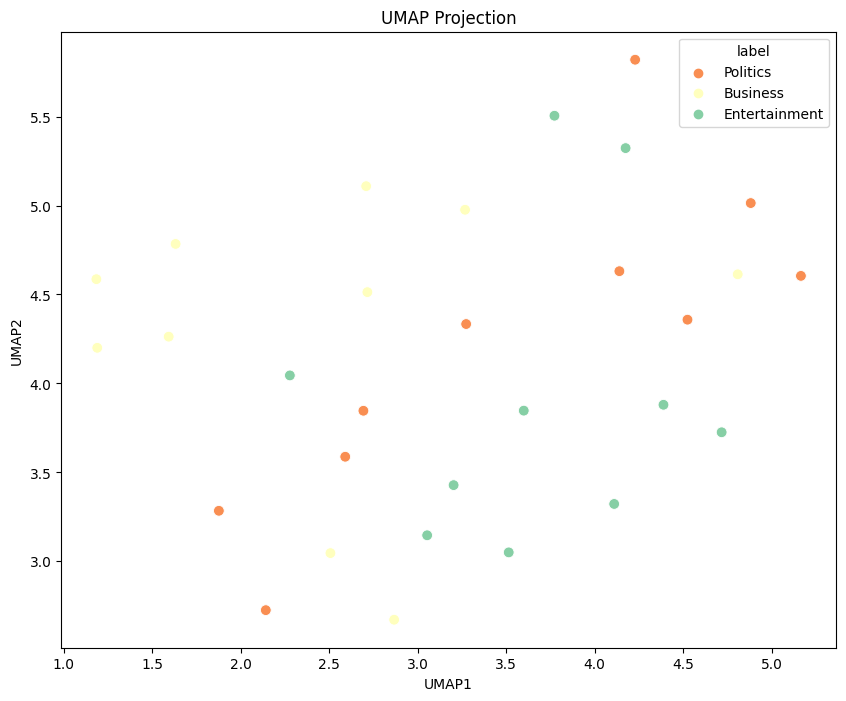

In [19]:
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt

features_df = point_could_features
labels_df = point_could_labels

# Combine the features and labels
data_with_labels = pd.concat([features_df, labels_df], axis=1)
data_with_labels.columns = list(features_df.columns) + ['label']

# Fit UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_df)

# Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = labels_df.values

# Plot the UMAP results
plt.figure(figsize=[10,8])
sns.scatterplot(x='UMAP1', y='UMAP2', hue='label', data=umap_df, palette='Spectral', s=60)
plt.title('UMAP Projection')
plt.show()

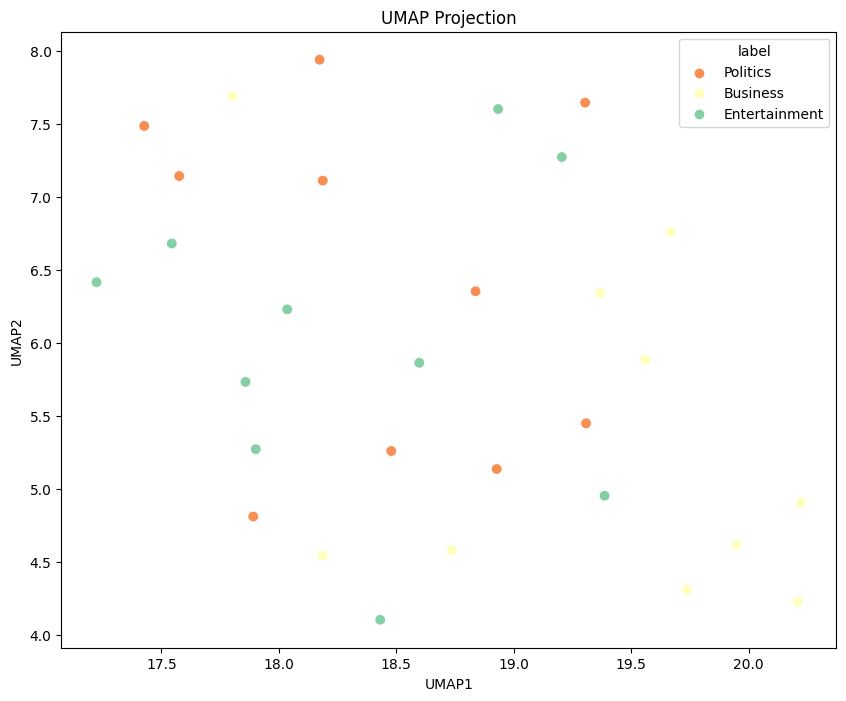

In [31]:
features_politics_dir = get_dataset_topological_features(attentions_politics, directed=True)
features_business_dir = get_dataset_topological_features(attentions_business, directed=True)
features_entertainment_dir = get_dataset_topological_features(attentions_entertainment, directed=True)

all_features_dir = features_politics_dir + features_business_dir + features_entertainment_dir
labels = ['Politics'] * len(features_politics) + ['Business'] * len(features_business) + ['Entertainment'] * len(features_entertainment)

# Generate dataframe
columns = generate_feature_names()
point_could_features = pd.DataFrame(all_features_dir, columns=columns)
point_could_labels = pd.DataFrame(labels, columns=['dataset'])

features_df = point_could_features
labels_df = point_could_labels

# Combine the features and labels
data_with_labels = pd.concat([features_df, labels_df], axis=1)
data_with_labels.columns = list(features_df.columns) + ['label']

# Fit UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_df)

# Create a DataFrame with the UMAP results
umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = labels_df.values

# Plot the UMAP results
plt.figure(figsize=[10,8])
sns.scatterplot(x='UMAP1', y='UMAP2', hue='label', data=umap_df, palette='Spectral', s=60)
plt.title('UMAP Projection')
plt.show()

# From paper

In [ ]:
# Code from Kushnareva, Laida et al. "Artificial Text Detection via Examining the Topology of Attention Maps"

import os
import re
import numpy as np

from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertModel


def cutoff_matrix(matrix, ntokens):
    """Return normalized submatrix of first n_tokens"""
    matrix = matrix[:ntokens, :ntokens]
    matrix /= matrix.sum(axis=1, keepdims=True)
    return matrix

def grab_attention_weights(model, tokenizer, sentences, MAX_LEN, device='cuda:0'):
    inputs = tokenizer.batch_encode_plus([text_preprocessing(s) for s in sentences],
                                       return_tensors='pt',
                                       add_special_tokens=True,
                                       max_length=MAX_LEN,             # Max length to truncate/pad
                                       pad_to_max_length=True,         # Pad sentence to max length)
                                       truncation=True
                                      )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs["token_type_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    attention = model(input_ids, attention_mask, token_type_ids)['attentions']
    # layer X sample X head X n_token X n_token
    attention = np.asarray([layer.cpu().detach().numpy() for layer in attention], dtype=np.float16)

    return attention

def grab_weights_for_all(reviews,
                         model_name='bert-base-multilingual-cased',
                         layer_of_interest=-1,
                         head_of_interest=0,
                         recalculate=True,
                         output_file='adj_matricies.npy'
                         ):
    """
    Returns attention weights (matricies) for each sentence from reviews, for
    chosen layer and head. If recalculate==False, loads such weights from .npy
    file. Otherwise, calculates them and saves into .npy file.

    Args:
        reviews (list[str])
        model_name (str)
        layer_of_interest (int)
        head_of_interest (int),
        recalculate (bool),
        output_file (str).

    Returns:
        np.array[int,int,int]
    """

    model = BertModel.from_pretrained(model_name, output_attentions=True)
    tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)


    r_file = Path(output_file)

    adj_matricies = []

    if r_file.is_file() and not recalculate:
        adj_matricies = np.load(r_file, allow_pickle=True)
        print("Loaded previously calculated weights.")

    else:
        for i in tqdm(range(len(reviews)),
                            desc="Weights calculation"):
            attention_w = grab_attention_weights(model, tokenizer, reviews[i])
            adj_matrix  = attention_w[layer_of_interest].detach().numpy()[0][head_of_interest]
            adj_matricies.append(adj_matrix)

        adj_matricies = np.asarray(adj_matricies)
        np.save(r_file, adj_matricies)

        print("Calculation results are saved to a file", r_file, ".")

    return adj_matricies

def get_filtered_mat_list(adj_matrix, thresholds_array, ntokens):
  """
  Converts adjancency matrix with real weights into list of binary matricies.
  For each threshold, those weights of adjancency matrix, which are less than
  threshold, get "filtered out" (set to 0), remained weights are set to ones.

  Args:
      adj_matrix (np.array[float, float])
      thresholds_array (iterable[float])
      n_tokens (int)

  Returns:
      filtered_matricies (list[np.array[int, int]])
  """
  filtered_matricies = []
  for thr in thresholds_array:
      filtered_matrix = adj_matrix.copy()
      filtered_matrix = cutoff_matrix(filtered_matrix, ntokens)
      filtered_matrix[filtered_matrix <  thr] = 0
      filtered_matrix[filtered_matrix >= thr] = 1
      filtered_matricies.append(filtered_matrix.astype(np.int8))
  return filtered_matricies

def adj_m_to_nx_list(adj_matrix, thresholds_array, ntokens, no_mat_output=False):
    """
    Converts adjancency matrix into list of unweighted digraphs, using filtering
    process from previous function.

    Args:
        adj_matrix (np.array[float, float])
        thresholds_array (iterable[float])
        n_tokens (int)

    Returns:
        nx_graphs_list (list[nx.MultiDiGraph])
        filt_mat_list(list[np.array[int, int]])

    """
#     adj_matrix = adj_matrix[:length,:length]
    filt_mat_list = get_filtered_mat_list(adj_matrix, thresholds_array, ntokens)
    nx_graphs_list = []
    for mat in filt_mat_list:
        nx_graphs_list.append(nx.from_numpy_matrix(np.array(mat), \
                              create_using=nx.MultiDiGraph()))
    if no_mat_output:
        return nx_graphs_list, []
    else:
        return nx_graphs_list, filt_mat_list

def adj_ms_to_nx_lists(adj_matricies, \
                       thresholds_array, \
                       ntokens_array, \
                       verbose=True, \
                       no_mat_output=False):
    """
    Executes adj_m_to_nx_list for each matrix in adj_matricies array, arranges
    the results. If verbose==True, shows progress bar.

    Args:
        adj_matrix (np.array[float, float])
        thresholds_array (iterable[float])
        verbose (bool)

    Returns:
        nx_graphs_list (list[nx.MultiDiGraph])
        filt_mat_lists (list[list[np.array[int,int]]])
    """
    graph_lists = []
    filt_mat_lists = []

    iterable = range(len(adj_matricies))
    if verbose:
        iterable = tqdm(range(len(adj_matricies)),
                        desc="Calc graphs list")
    for i in iterable:
        g_list, filt_mat_list = adj_m_to_nx_list(adj_matricies[i],\
                                                 thresholds_array,\
                                                 ntokens_array[i], \
                                                 no_mat_output=no_mat_output)
        graph_lists.append(g_list)
        filt_mat_lists.append(filt_mat_lists)

    return graph_lists, filt_mat_lists


In [ ]:
max_tokens_amount  = 128 # The number of tokens to which the tokenized text is truncated / padded.
stats_cap          = 500 # Max value that the feature can take. Is NOT applicable to Betty numbers.

layers_of_interest = [i for i in range(12)]  # Layers for which attention matrices and features on them are
                                             # calculated. For calculating features on all layers, leave it be
                                             # [i for i in range(12)].
stats_name = "s_e_v_c_b0b1" # The set of topological features that will be count (see explanation below)

thresholds_array = [0.025, 0.05, 0.1, 0.25, 0.5, 0.75] # The set of thresholds
thrs = len(thresholds_array)                           # ("t" in the paper)

model_path = tokenizer_path = "bert-base-uncased"

device='cuda:1'
model = BertForSequenceClassification.from_pretrained(model_path, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, do_lower_case=True)
model = model.to(device)
MAX_LEN = max_tokens_amount